In [12]:
#Resume Screening NLP Final Exam Project

import pandas as pd

# Resume dataset from kaggle https://www.kaggle.com/datasets/gauravduttakiit/resume-dataset
df = pd.read_csv('UpdatedResumeDataSet.csv')

df.tail()

df.shape

df['Category'].value_counts().head(10)


Category
Java Developer        84
Testing               70
DevOps Engineer       55
Python Developer      48
Web Designing         45
HR                    44
Hadoop                42
Blockchain            40
ETL Developer         40
Operations Manager    40
Name: count, dtype: int64

In [13]:
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

nltk.download('stopwords')

#clean resume text
def clean_resume(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

df['cleaned_resume'] = df['Resume'].apply(clean_resume)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

#Split data
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_resume'], df['Category'], test_size=0.2, random_state=42)

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_tfidf, y_train)

y_pred_rf = rf_model.predict(X_test_tfidf)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print(f'Random Forest Accuracy: {accuracy_rf}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Random Forest Accuracy: 0.9948186528497409


In [34]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical

# Tokenize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_resume'])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

y_train_enc = to_categorical(y_train, num_classes=25)
y_test_enc = to_categorical(y_test, num_classes=25)

# Keras Conv1D model
conv1d_model = Sequential()
conv1d_model.add(Embedding(input_dim=5000, output_dim=100, input_length=max_len))
conv1d_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
conv1d_model.add(MaxPooling1D(pool_size=2))
conv1d_model.add(Flatten())
conv1d_model.add(Dense(128, activation='relu'))
conv1d_model.add(Dropout(0.5))
conv1d_model.add(Dense(25, activation='softmax'))

conv1d_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

conv1d_model.fit(X_train_pad, y_train_enc, epochs=10, batch_size=32, validation_split=0.2)

loss, accuracy_conv1d = conv1d_model.evaluate(X_test_pad, y_test_enc)
print(f'Keras Conv1D Accuracy: {accuracy_conv1d}')


Epoch 1/10
20/20 [==============================] - 9s 272ms/step - loss: 2.9807 - accuracy: 0.1480 - val_loss: 2.6664 - val_accuracy: 0.2987
Epoch 2/10
20/20 [==============================] - 3s 130ms/step - loss: 1.9634 - accuracy: 0.5122 - val_loss: 1.5831 - val_accuracy: 0.7792
Epoch 3/10
20/20 [==============================] - 2s 95ms/step - loss: 0.9124 - accuracy: 0.8081 - val_loss: 0.6503 - val_accuracy: 0.9156
Epoch 4/10
20/20 [==============================] - 3s 154ms/step - loss: 0.3371 - accuracy: 0.9382 - val_loss: 0.2747 - val_accuracy: 0.9545
Epoch 5/10
20/20 [==============================] - 3s 129ms/step - loss: 0.1337 - accuracy: 0.9870 - val_loss: 0.1678 - val_accuracy: 0.9740
Epoch 6/10
20/20 [==============================] - 2s 91ms/step - loss: 0.0803 - accuracy: 0.9870 - val_loss: 0.1577 - val_accuracy: 0.9740
Epoch 7/10
20/20 [==============================] - 2s 99ms/step - loss: 0.0430 - accuracy: 0.9951 - val_loss: 0.1528 - val_accuracy: 0.9740
Epoch 8/1

In [10]:
from gensim.models import Word2Vec
from keras.layers import LSTM

#Word2Vec model
sentences = [text.split() for text in df['cleaned_resume']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


embedding_matrix = np.zeros((5000, 100))
for word, i in tokenizer.word_index.items():
    if i < 5000:
        try:
            embedding_vector = w2v_model.wv[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            pass

# LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=100, input_length=max_len, weights=[embedding_matrix], trainable=False))
lstm_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(25, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lstm_model.fit(X_train_pad, y_train_enc, epochs=10, batch_size=32, validation_split=0.2)

loss, accuracy_lstm_w2v = lstm_model.evaluate(X_test_pad, y_test_enc)
print(f'LSTM with Word2Vec Accuracy: {accuracy_lstm_w2v}')


Epoch 1/10
20/20 [==============================] - 16s 621ms/step - loss: 3.0782 - accuracy: 0.1236 - val_loss: 2.9268 - val_accuracy: 0.1818
Epoch 2/10
20/20 [==============================] - 12s 615ms/step - loss: 2.7320 - accuracy: 0.2439 - val_loss: 2.5968 - val_accuracy: 0.3182
Epoch 3/10
20/20 [==============================] - 12s 608ms/step - loss: 2.3301 - accuracy: 0.3447 - val_loss: 2.2942 - val_accuracy: 0.4091
Epoch 4/10
20/20 [==============================] - 12s 611ms/step - loss: 1.9861 - accuracy: 0.4504 - val_loss: 2.0097 - val_accuracy: 0.4481
Epoch 5/10
20/20 [==============================] - 11s 565ms/step - loss: 1.6912 - accuracy: 0.5707 - val_loss: 1.6372 - val_accuracy: 0.6494
Epoch 6/10
20/20 [==============================] - 11s 522ms/step - loss: 1.3640 - accuracy: 0.6407 - val_loss: 1.3037 - val_accuracy: 0.6688
Epoch 7/10
20/20 [==============================] - 12s 598ms/step - loss: 1.1310 - accuracy: 0.6927 - val_loss: 1.0729 - val_accuracy: 0.7403

In [30]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import numpy as np


# Data cleaning function
def clean_resume(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text


df['cleaned_resume'] = df['Resume'].apply(clean_resume)


le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])

X_train, X_test, y_train, y_test = train_test_split(df['cleaned_resume'], df['Category'], test_size=0.2, random_state=42)

# BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=25)

#
max_len = 128
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_len)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_len)

# Convert to TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).shuffle(len(X_train)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test)).batch(16)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-7)

# Train the model
history = model.fit(train_dataset, epochs=3, validation_data=test_dataset, callbacks=[early_stopping, reduce_lr])

# Evaluating
loss, accuracy_bert = model.evaluate(test_dataset)
print(f'BERT Accuracy: {accuracy_bert}')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
49/49 [==============================] - 69s 561ms/step - loss: 3.0116 - accuracy: 0.1625 - val_loss: 2.6177 - val_accuracy: 0.2953 - lr: 3.0000e-05
Epoch 2/3
49/49 [==============================] - 23s 474ms/step - loss: 2.2404 - accuracy: 0.5696 - val_loss: 1.6423 - val_accuracy: 0.8342 - lr: 3.0000e-05
Epoch 3/3
13/13 [==============================] - 2s 133ms/step - loss: 0.9574 - accuracy: 0.9637
BERT Accuracy: 0.9637305736541748


13/13 [==============================] - 2s 158ms/step
Random Forest Accuracy: 0.9948186528497409
Keras Conv1D Accuracy: 0.9637305699481865
LSTM with Word2Vec Accuracy: 0.8808290155440415
BERT Accuracy: 0.9637305699481865


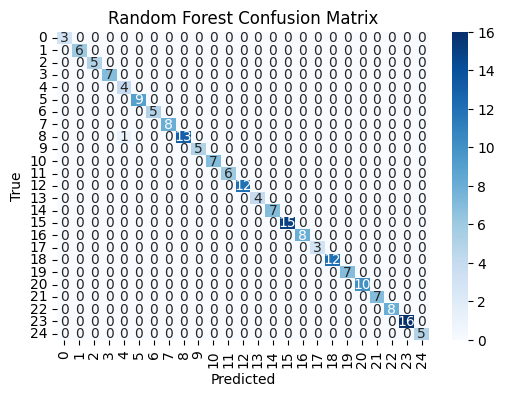

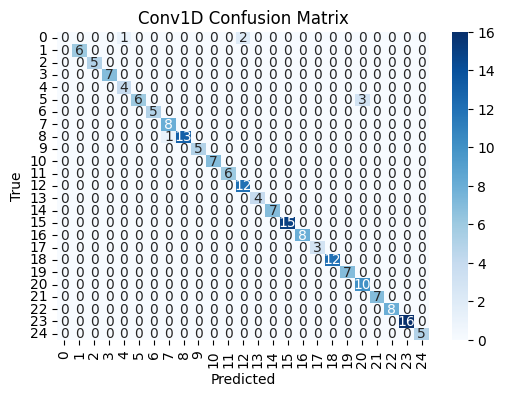

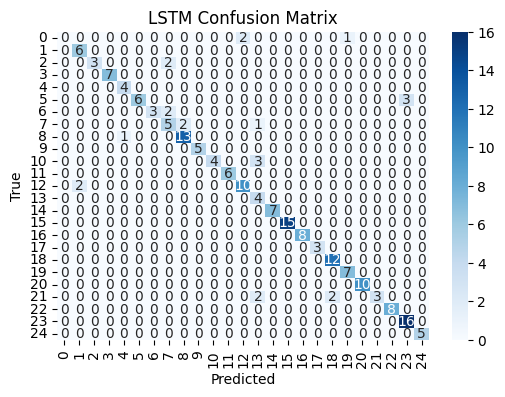

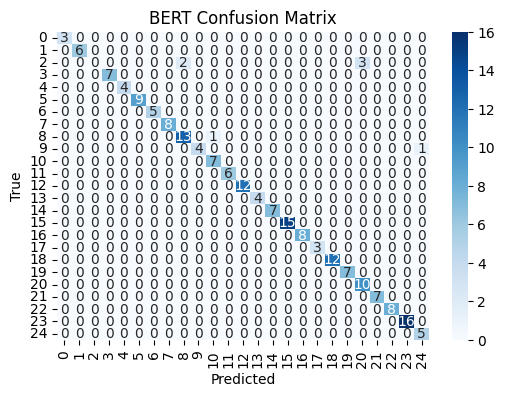

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

y_pred_rf = rf_model.predict(X_test_tfidf)

y_pred_conv1d_prob = conv1d_model.predict(X_test_pad)
y_pred_conv1d = np.argmax(y_pred_conv1d_prob, axis=1)

y_pred_lstm_prob = lstm_model.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)

preds = model.predict(test_dataset)
y_pred_bert = np.argmax(preds.logits, axis=1)

# Compute confusion matrices
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_conv1d = confusion_matrix(y_test, y_pred_conv1d)
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
conf_matrix_bert = confusion_matrix(y_test, y_pred_bert)

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_conv1d = accuracy_score(y_test, y_pred_conv1d)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
accuracy_bert = accuracy_score(y_test, y_pred_bert)

print('Random Forest Accuracy:', accuracy_rf)
print('Keras Conv1D Accuracy:', accuracy_conv1d)
print('LSTM with Word2Vec Accuracy:', accuracy_lstm)
print('BERT Accuracy:', accuracy_bert)

#plot confusion matrices
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(conf_matrix_rf, 'Random Forest Confusion Matrix')
plot_confusion_matrix(conf_matrix_conv1d, 'Conv1D Confusion Matrix')
plot_confusion_matrix(conf_matrix_lstm, 'LSTM Confusion Matrix')
plot_confusion_matrix(conf_matrix_bert, 'BERT Confusion Matrix')
